In order to work, this notebook expects in input the dataset, with two folders: 'Images' and 'Masks'

The splitting between train and validation is done by specifying, in a third folder, 'Splits', two text files containing the names of the images, one is called train.txt, the other one val.txt

The script to generate these files is in the attached zip

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import os

import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import *

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 7091998
tf.random.set_seed(SEED) 

In [4]:
cwd = os.getcwd()
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!cp "/content/drive/My Drive/datasets/FULL_DATASET.zip" "/content/FULL_DATASET.zip"
!unzip -oq "/content/FULL_DATASET.zip" -d "/content/data/"

In [5]:
# CONSTANTS AND HYPERPARAMETERS

IMG_SHAPE = [224, 224, 3]
NONE_SHAPE = [None, None, 3]
IMG_SIZE = IMG_SHAPE[:2]
MASK_SHAPE = [224, 224, 1]
class_colors=[(0, 0, 0), (255, 255, 255), (216, 67, 82)]
OUTPUT_CHANNELS = 3

bs = 4

SMALL_CROP_SZ = [224, 224, 3]
MED_CROP_SZ = [448, 448, 3]
BIG_CROP_SZ = [672, 672, 3]

MASK_MEDIUM = [448, 448, 1]
MASK_BIG = [672, 672, 1]

# COLOR
BG_COLOR = [0, 0, 0]
OTHER_BG_COLOR = [254, 124, 18]
PLANT_COLOR = [255, 255, 255]
WEED_COLOR = [216, 67, 82]

# Nice sizes
BIPBIP_NICE_SZ = (2048, 1536)
WEEDELEC_NICE_SZ = (2592, 1728)
PEAD_NICE_SZ = (2496, 1920)
ROSEAU_NICE_SZ = (1024, 768)

# Eval things
EVAL_SZ = (1792, 896)
EVAL_IMG = [896, 1792, 3]
EVAL_MSK = [896, 1792, 1]

N_CLASSES = 3

debug = False

## Data generation things

In [6]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=90,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=90,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [7]:
import albumentations as A

albumentations = ['hueSaturationValue', 'randomBrightnessContrast', 'rgbShift', 'randomRotate90', 'flip']

def apply_albumentation(image, mask, max_trans=1):
  trans = []
  img = image
  msk = mask
  # Select max_trans random transformations
  for i in range(max_trans):
    t = random.choice(albumentations)
    trans.append(t)
  
  for t in trans:
    if debug:
      print('Current transformation: {}'.format(t))
    if t == 'channelShuffle':
      curr_t = A.ChannelShuffle(p=1)
      img = curr_t(image=img)['image']
    elif t == 'hueSaturationValue':
      curr_t = A.HueSaturationValue(p=1)
      img = curr_t(image=img)['image']
    elif t == 'randomBrightnessContrast':
      curr_t = A.RandomBrightnessContrast(p=1)
      img = curr_t(image=img)['image']
    elif t == 'rgbShift':
      curr_t = A.RGBShift(p=1)
      img = curr_t(image=img)['image']
    elif t == 'randomRotate90':
      curr_t = A.RandomRotate90(p=1)
      aug = curr_t(image=img, mask=msk)
      img = aug['image']
      msk = aug['mask']
    elif t == 'flip':
      curr_t = A.Flip(p=1)
      aug = curr_t(image=img, mask=msk)
      img = aug['image']
      msk = aug['mask']

  return img, msk

In [8]:
from PIL import Image, ImageFilter
import random

random.seed(SEED)

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=IMG_SIZE, image_style='resized', filter=None, augumentation=True):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.image_style = image_style
    self.filter = filter
    self.augumentation = augumentation

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename))
    mask = Image.open(os.path.join(self.dataset_dir, 'Masks', curr_filename.replace('jpg', 'png')))

    if debug:
      print('Current image: {}'.format(curr_filename))

    if self.image_style == 'small_crop' or self.image_style == 'medium_crop' or self.image_style == 'big_crop':
      no_full_bg = False

      # Take a random crop of the image
      if self.image_style == 'small_crop':
        target_x = SMALL_CROP_SZ[0]
        target_y = SMALL_CROP_SZ[1]
      elif self.image_style == 'medium_crop':
        target_x = MED_CROP_SZ[0]
        target_y = MED_CROP_SZ[1]
      elif self.image_style == 'big_crop':
        target_x = BIG_CROP_SZ[0]
        target_y = BIG_CROP_SZ[1]
      
      x_sz, y_sz = img.size

      while no_full_bg == False:
        # Take a random point within the boundaries
        x_origin = random.randint(0, x_sz - target_x)
        y_origin = random.randint(0, y_sz - target_y)
        # Crop
        crop_params = (x_origin, y_origin, x_origin + target_x, y_origin + target_y)
        t_img = img.crop(crop_params)
        t_mask = mask.crop(crop_params)

        # Check to see if there is only bg in the cropped img
        t_mask_arr = np.array(t_mask)
        if np.all(t_mask_arr == BG_COLOR, axis=-1).all():
          no_full_bg = False
        else:
          no_full_bg = True
      
      img = t_img
      mask = t_mask

    elif self.image_style == 'resized':
      # Resize image and mask
      img = img.resize(self.out_shape)
      mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    elif self.image_style == 'eval':
      img = img.resize(EVAL_SZ)
      mask = mask.resize(EVAL_SZ)

    elif self.image_style == 'full':
      new_y = 896
      new_x = 1792
      # Must reduce the dimension a bit, due to memory issues
      if 'Roseau' in curr_filename:
        new_y = ROSEAU_NICE_SZ[1]
        new_x = ROSEAU_NICE_SZ[0]
      elif 'Weedelec' in curr_filename:
        new_y = WEEDELEC_NICE_SZ[1]
        new_x = WEEDELEC_NICE_SZ[0]
      elif 'Bipbip' in curr_filename:
        new_y = BIPBIP_NICE_SZ[1]
        new_x = BIPBIP_NICE_SZ[0]
      elif 'Pead' in curr_filename:
        new_y = PEAD_NICE_SZ[1]
        new_x = PEAD_NICE_SZ[0]
      
      new_shape = (new_x, new_y)
      img = img.resize(new_shape)
      mask = mask.resize(new_shape)

    if self.filter is not None:
      img = img.filter(self.filter)

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    out_mask = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    out_mask = np.expand_dims(out_mask, -1)
    out_mask[np.where(np.all(mask_arr == OTHER_BG_COLOR, axis=-1))] = 0
    out_mask[np.where(np.all(mask_arr == PLANT_COLOR, axis=-1))] = 1
    out_mask[np.where(np.all(mask_arr == WEED_COLOR, axis=-1))] = 2

    if self.which_subset == 'training' and self.augumentation:
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        n_trans = random.choice([0, 1, 2])
        if debug:
          print('Applying {} transformations'.format(n_trans))
        img_arr, out_mask = apply_albumentation(img_arr, out_mask, max_trans=n_trans)

    if self.preprocessing_function is not None:
        img_arr = np.float32(img_arr)
        img_arr = self.preprocessing_function(img_arr)

    return np.float32(img_arr), np.float32(out_mask)

In [9]:
preprocess =  tf.keras.applications.resnet.preprocess_input
filter = None

crop_size = 'medium_crop'

In [20]:
from PIL import ImageFilter


dataset = CustomDataset('/content/data/FULL_DATASET', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess, image_style=crop_size, filter=filter, augumentation=True)
dataset_valid = CustomDataset('/content/data/FULL_DATASET', 'validation', 
                              preprocessing_function=preprocess, image_style=crop_size)

FileNotFoundError: ignored

In [28]:
if crop_size == 'small_crop':
  shapes = (SMALL_CROP_SZ, MASK_SHAPE)
elif crop_size == 'medium_crop':
  shapes = (MED_CROP_SZ, MASK_MEDIUM)
elif crop_size == 'big_crop':
  shapes = (BIG_CROP_SZ, MASK_BIG)

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=shapes).batch(bs).repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=shapes).batch(8).repeat()

In [8]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

batch_size = 1

iterator = iter(train_dataset)

plt.figure(figsize=(30, 5))

def next_img():
  image, msk = next(iterator)
  print('Image shape: {}'.format(image.shape))
  print('Mask shape: {}'.format(msk.shape))

  plt.figure(figsize=(30,5*batch_size))
  if True:
    for i in range(batch_size):
      plt.subplot(batch_size, 3, 3*i+1)
      plt.imshow(image[0] / 255.)
      #plt.axis('off')
      plt.subplot(batch_size, 3, 3*i+2)
      msk = np.apply_along_axis(lambda x: class_colors[x[0]], -1, np.int8(msk[0]))
      plt.imshow(msk / 255.)
      #plt.axis('off')

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (4, 448, 448, 3)
Mask shape: (4, 448, 448, 1)


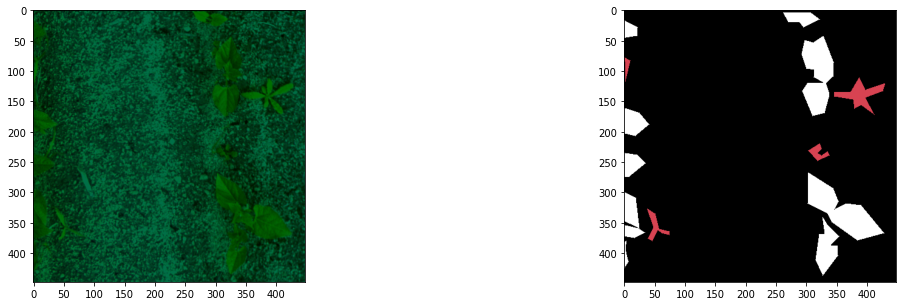

In [12]:
next_img()

## Encoder / Decoder things

In [10]:
get_outs = True

def get_encoder(name, input_shape, unfreezed=0):
  if name == 'resnet50':
    base_model = tf.keras.applications.ResNet50(
                      include_top=False, weights='imagenet',
                      input_shape=input_shape)
    layer_names = [
                'conv1_relu',   
                'conv2_block3_out', 
                'conv3_block4_out',
                'conv4_block6_out',
                'conv5_block3_out' ]

  elif name == 'vgg16':
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    layer_names = [
                'block1_conv2',
                'block2_conv2',
                'block3_conv3',
                'block4_conv3',
                'block5_conv3' ]
  
  # Things to do everytime
  # ------------------------
  attach_layers = []
  if get_outs:
    for layer in reversed(layer_names):
        l = base_model.get_layer(name=layer).output
        attach_layers.append(l)

    for la in base_model.layers:
      la.trainable = False

    n_layers = len(base_model.layers)
    for la in base_model.layers[n_layers-unfreezed:]:
      la.trainable = True

    enc = tf.keras.Model(inputs=base_model.input, outputs=attach_layers, name='encoder')

    return enc
  else:
    return base_model

get_encoder(name='resnet50', input_shape=IMG_SHAPE).summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, concatenate, BatchNormalization, Input, Conv2DTranspose

def get_unet(encoder, encoder_name, start_filters, n_classes, batch_norm=False, additional_conv=False, input_shape=NONE_SHAPE, unfreezed=0):
  
  inp = Input(shape=NONE_SHAPE)
  
  enc=encoder(encoder_name, input_shape=input_shape, unfreezed=unfreezed)
  f=start_filters

  skip_connections = enc(inp)

  for i in range(len(skip_connections)):
    if i == 0:
      # Start of up_stack
      m = skip_connections[i]
    else:
      # Upsampling with concatenate
      m = UpSampling2D((2, 2), interpolation='bilinear')(m)
      m = concatenate([m, skip_connections[i]], axis=-1)
    # Standard conv-conv block
    if i <= 3 and additional_conv:
      m = Conv2D(f, (3, 3), padding='same', activation='relu')(m)
      m = Dropout(0.2)(m)

    m = Conv2DTranspose(
        filters=f,
        kernel_size=3,
        padding='same',
        activation='relu')(m)
    if batch_norm:
      m = BatchNormalization()(m)
    f = f // 2

  # One last Upsampling
  m = UpSampling2D((2, 2), interpolation='bilinear')(m)
  m = Conv2DTranspose(
        filters=f,
        kernel_size=3,
        padding='same',
        activation='relu')(m)
  if batch_norm:
    m = BatchNormalization()(m)

  # Final prediction layer
  m = Conv2DTranspose(
        filters=n_classes,
        kernel_size=2,
        strides=1,
        padding='same',
        activation='softmax')(m)

  model = tf.keras.Model(inputs=inp, outputs=m, name='thatUnet')
  
  return model


Model: "thatUnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, None, None,  23587712    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, None, None, 5 9437696     encoder[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 5 2048        conv2d_transpose[0][0]           
___________________________________________________________________________________________

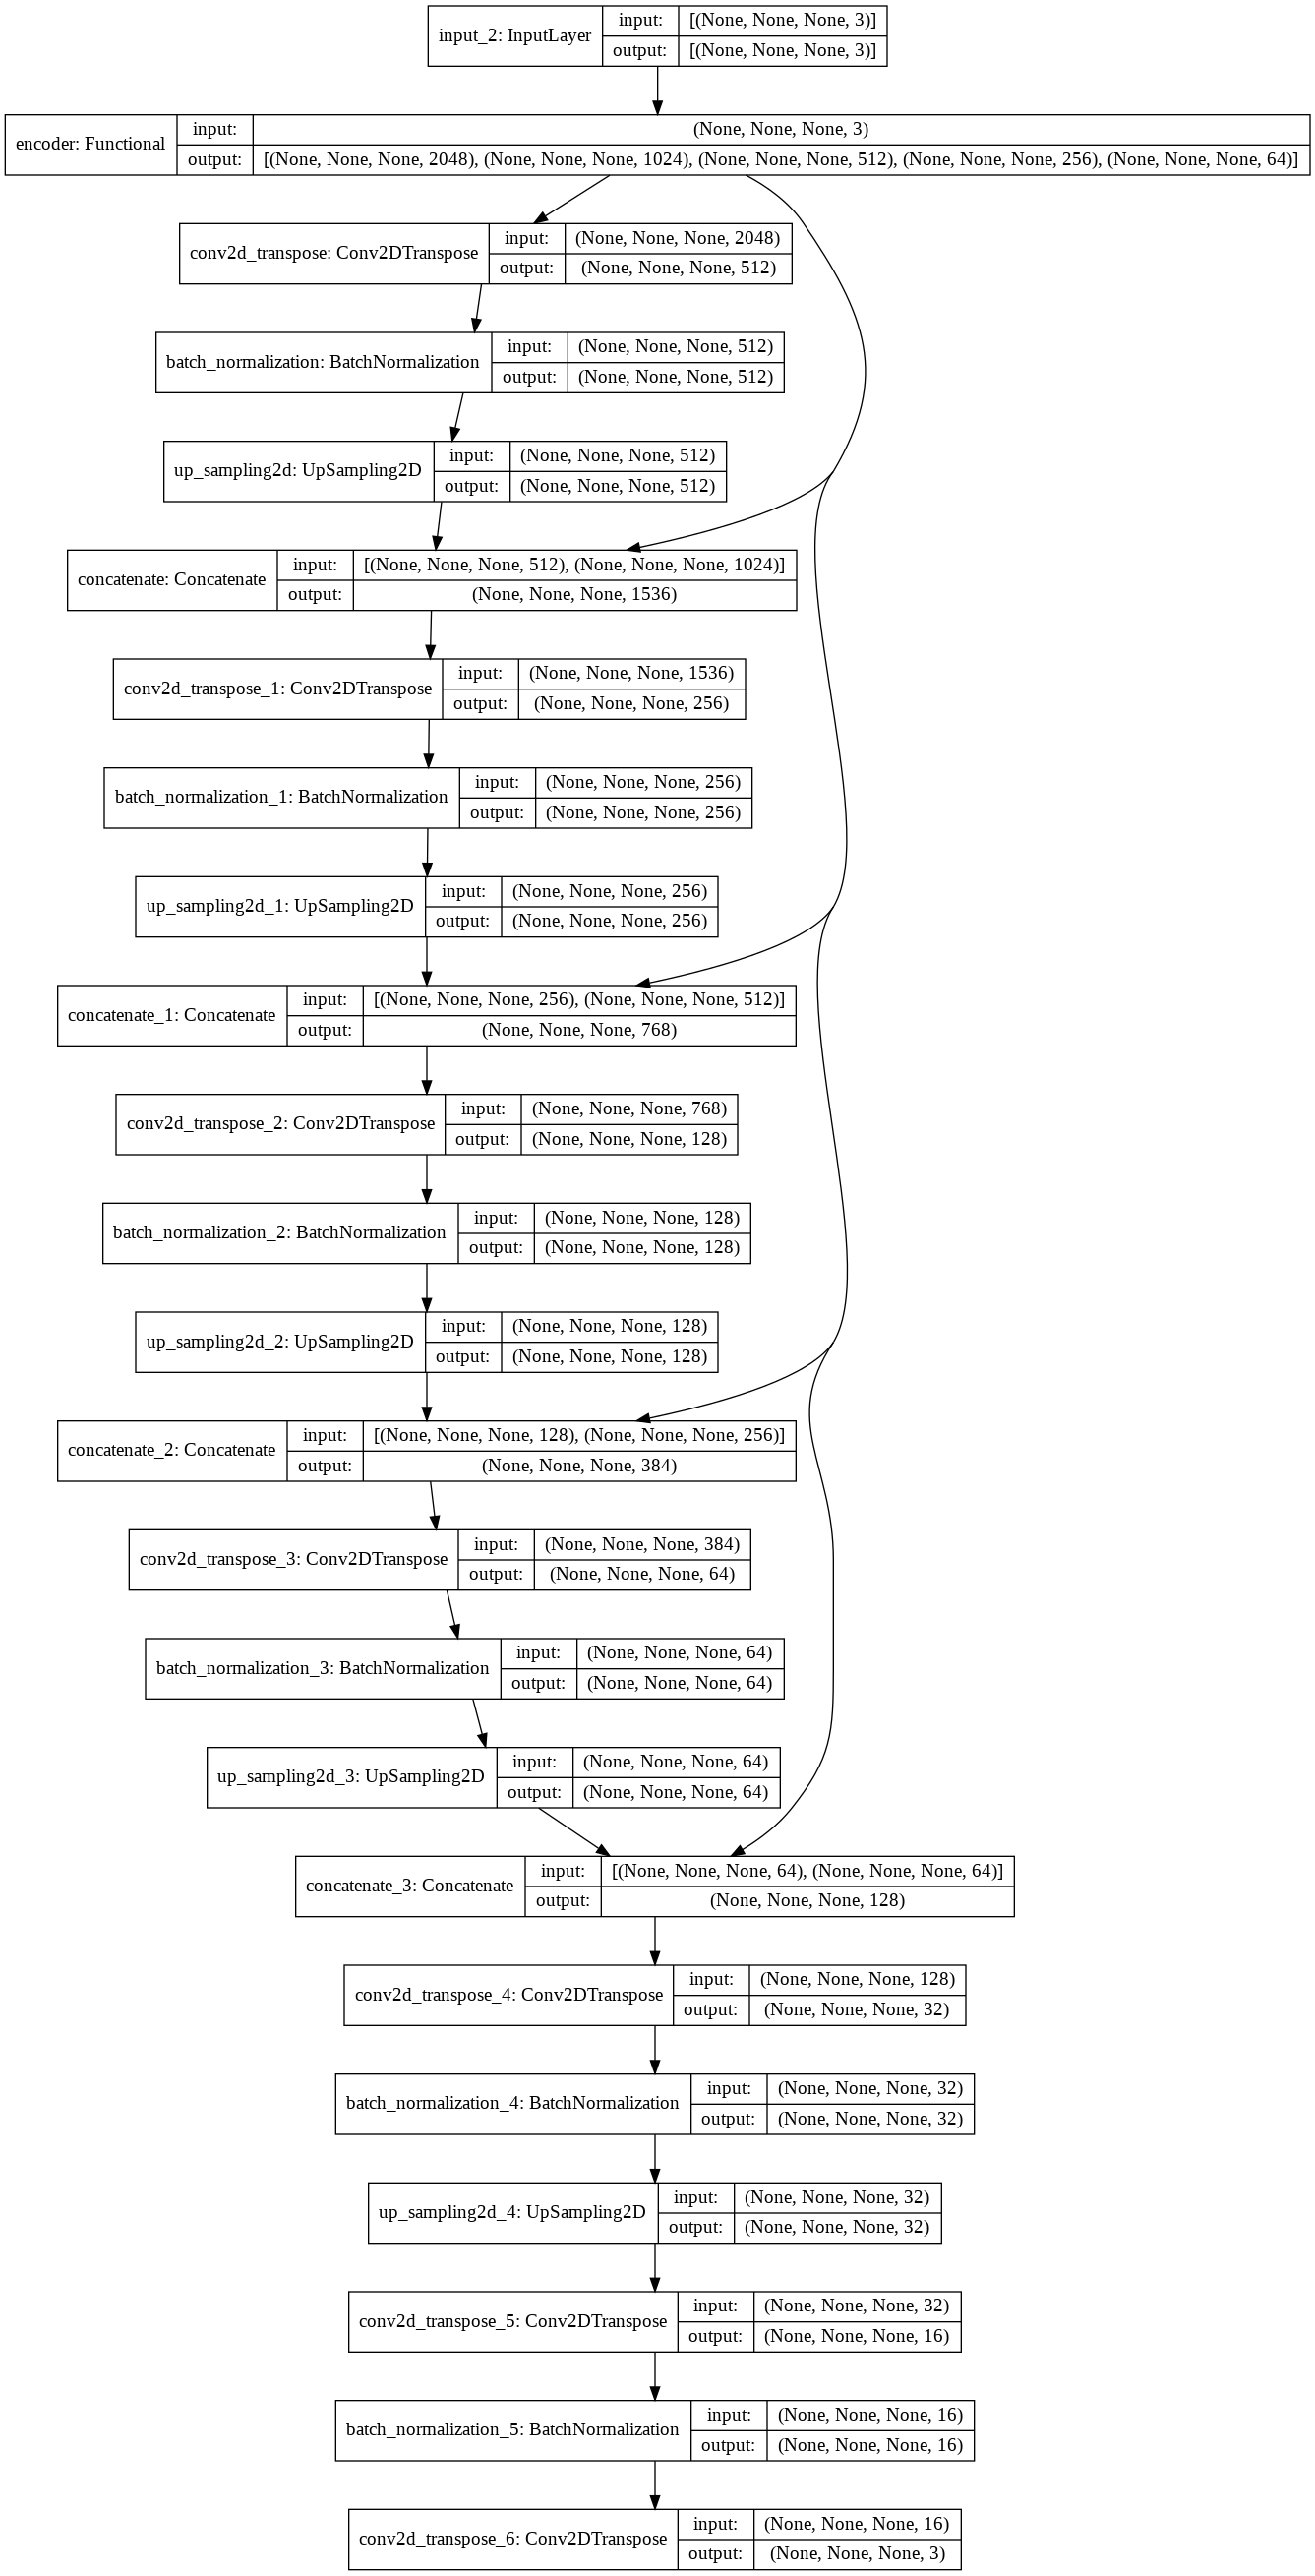

In [12]:
model = get_unet(get_encoder, 'resnet50', start_filters=512, n_classes=3, batch_norm=True, input_shape=NONE_SHAPE)

model.summary()

plot_model(model, show_shapes=True)

## Model run things

In [13]:
def sparse_cc_fuljo(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.one_hot(tf.squeeze(y_true), depth=N_CLASSES)
    epsilon = tf.constant(tf.keras.backend.epsilon(), tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.-epsilon)

    res = y_true * tf.math.log(y_pred)
    res = tf.reduce_mean(res)

    return -res

In [15]:
# Optimization params
# -------------------

# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
lr = 1e-3
loss = sparse_cc_fuljo
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.99)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(3):
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return (tf.reduce_mean(per_class_iou))

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

In [35]:

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [16]:
from datetime import datetime

def get_callbacks():
  cwd = os.getcwd()

  exps_dir = os.path.join(cwd, 'drive/My Drive/Segmentation/', 'challenge')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  model_name = 'segm'

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                    save_weights_only=True,
                                                    save_best_only=True)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                              profile_batch=0,
                                              histogram_freq=0)  # if 1 shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  early_stop = True
  if early_stop:
      es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
      callbacks.append(es_callback)

  # Plateu fix with lr
  # --------------
  lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

  callbacks.append(lr_callback)

  return callbacks

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Segmentation/challenge/

In [37]:
# Due to memory limitations, we had to validate on half of the validation set at every epoch

model.fit(x=train_dataset,
          epochs=50,
          steps_per_epoch=len(dataset) // bs,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid) // (16), 
          callbacks=get_callbacks())

Epoch 1/50
168/168 [==============================] - 230s 1s/step - loss: 0.2134 - accuracy: 0.8228 - meanIoU: 0.4532 - val_loss: 0.0869 - val_accuracy: 0.9312 - val_meanIoU: 0.6318
Epoch 2/50
168/168 [==============================] - 215s 1s/step - loss: 0.0672 - accuracy: 0.9343 - meanIoU: 0.5787 - val_loss: 0.0463 - val_accuracy: 0.9534 - val_meanIoU: 0.7012
Epoch 3/50
168/168 [==============================] - 213s 1s/step - loss: 0.0607 - accuracy: 0.9375 - meanIoU: 0.6222 - val_loss: 0.0316 - val_accuracy: 0.9666 - val_meanIoU: 0.7144
Epoch 4/50
168/168 [==============================] - 213s 1s/step - loss: 0.0529 - accuracy: 0.9457 - meanIoU: 0.6675 - val_loss: 0.0376 - val_accuracy: 0.9604 - val_meanIoU: 0.7547
Epoch 5/50
168/168 [==============================] - 212s 1s/step - loss: 0.0431 - accuracy: 0.9554 - meanIoU: 0.6878 - val_loss: 0.0383 - val_accuracy: 0.9578 - val_meanIoU: 0.7279
Epoch 6/50
168/168 [==============================] - 214s 1s/step - loss: 0.0426 - a

## Test Model

In [17]:
# Get model weights
# --------------------
cwd = os.getcwd()
test_model = True

got_model = False

if got_model:
  mod = fine_model
else:
  model_name = 'segm_Jan22_17-18-24'
  ckpt_name = 'cp_22.ckpt'

  model_dir = os.path.join(cwd, 'drive', 'My Drive', 'Segmentation', 'challenge')
  ckpt_dir = os.path.join(model_dir, model_name, 'ckpts', ckpt_name)
  mod = get_unet(get_encoder, 'resnet50', start_filters=512, n_classes=3, batch_norm=True, input_shape=NONE_SHAPE)
  mod.load_weights(ckpt_dir)

In [ ]:
dataset_test = CustomDataset('/content/data/FULL_DATASET', 'validation', preprocessing_function=preprocess, image_style='full')

test_data = tf.data.Dataset.from_generator(lambda: dataset_test,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=None).batch(1)


test_iterator = iter(test_data)

In [ ]:
# Generate prediction
# --------------------

batch_size = 1
class_colors=[(0, 0, 0), (255, 255, 255), (216, 67, 82)]

images, labels = next(test_iterator)
for i in range(batch_size):
  print('Dimesioni: {} - {}'.format(images[i].shape, labels[i].shape))
f = tf.keras.backend.function(mod.input, mod.output)
predictions = f(images)
predictions = tf.argmax(predictions, axis=-1)
predictions = tf.expand_dims(predictions, -1)

plt.figure(figsize=(30,5*batch_size))
for i in range(batch_size):
    plt.subplot(batch_size, 3, 3*i+1)
    plt.imshow(images[i])
    #plt.axis('off')
    plt.subplot(batch_size, 3, 3*i+2)
    msk = np.apply_along_axis(lambda x: class_colors[x[0]], -1, np.int8(predictions[i]))
    plt.imshow(msk / 255.)
    #plt.axis('off')
    plt.subplot(batch_size, 3, 3*i+3)
    msk = np.apply_along_axis(lambda x: class_colors[x[0]], -1, np.int8(labels[i]))
    plt.imshow(msk / 255.)
    #plt.axis('off')

## Evaluate model

In [ ]:
eval_generator = CustomDataset('/content/data/FULL_DATASET', 'validation', 
                                preprocessing_function=preprocess, image_style='eval')
eval_dataset = tf.data.Dataset.from_generator(lambda: eval_generator,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=(EVAL_IMG, EVAL_MSK)).batch(2)


In [ ]:
eval_model = mod

eval_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

eval_model.evaluate(x=eval_dataset)

## Fine Tuning

In [ ]:
# Unfreeze a bit
# ----------------

fine_model = get_unet(get_encoder, 'resnet50', start_filters=512, n_classes=3, batch_norm=True, input_shape=NONE_SHAPE, unfreezed=4)

# Get those weights
# -----------------
model_name = 'segm_Jan22_13-52-53'
ckpt_name = 'cp_06.ckpt'

model_dir = os.path.join(cwd, 'drive', 'My Drive', 'Segmentation', 'challenge')
ckpt_dir = os.path.join(model_dir, model_name, 'ckpts', ckpt_name)

fine_model.load_weights(ckpt_dir)

fine_model.summary()
# Fine tuning params
# ------------------
fine_lr = 1e-5
fine_loss = tf.keras.losses.sparse_categorical_crossentropy
fine_optimizer = tf.keras.optimizers.Adam(learning_rate=fine_lr)

In [ ]:
fine_model.compile(optimizer=fine_optimizer, loss=fine_loss, metrics=metrics)

In [ ]:
fine_model.fit(x=train_dataset,
          epochs=50,
          initial_epoch=6,
          steps_per_epoch=np.ceil(len(dataset) // (bs)),
          validation_data=valid_dataset,
          validation_steps=np.ceil(len(dataset_valid) // (16)), 
          callbacks=get_callbacks())

## Final Layer training only


In [ ]:
last_model = get_unet(get_encoder, 'resnet50', start_filters=512, n_classes=3, batch_norm=True, input_shape=NONE_SHAPE)

model_name = 'segm_Dec16_18-29-14'
ckpt_name = 'cp_06.ckpt'

model_dir = os.path.join(cwd, 'drive', 'My Drive', 'Segmentation', 'challenge')
ckpt_dir = os.path.join(model_dir, model_name, 'ckpts', ckpt_name)

last_model.load_weights(ckpt_dir)

unf = 1

for lay in last_model.layers[:-unf]:
  lay.trainable = False

last_model.summary()

In [ ]:
# Fitting parameters

last_layer_opt = tf.keras.optimizers.Adam(lr=1e-4)
last_layer_loss = tf.keras.losses.SparseCategoricalCrossentropy()
last_layer_metrics = ['accuracy', meanIoU]

last_model.compile(optimizer=last_layer_opt, loss=last_layer_loss, metrics=last_layer_metrics)

In [ ]:
last_model.fit(x=train_dataset,
          epochs=50,
          steps_per_epoch=len(dataset) // bs,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid) // (bs*2), 
          callbacks=get_callbacks())

## Model Save, for computing predictions

In [ ]:
models_dir = '/content/drive/MyDrive/Segmentation/models'
model_name = 'resnet50fine.h5'

model_save_dir = os.path.join(models_dir, model_name)

fine_model.save(model_save_dir)

## Test model on test data

In [18]:
!cp "/content/drive/My Drive/datasets/testset_final.zip" "/content/testset_final.zip"
!unzip -oq "/content/testset_final.zip" -d "/content/data/"

In [19]:
import os
import json
import numpy as np
from PIL import Image

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def add_single_prediction(sub_dictionary, mask_arr, img_name, team, crop_type, shape):
  submission_dict = sub_dictionary
  submission_dict[img_name] = {}
  submission_dict[img_name]['shape'] = shape
  submission_dict[img_name]['team'] = team
  submission_dict[img_name]['crop'] = crop_type
  submission_dict[img_name]['segmentation'] = {}

  # RLE encoding
  # crop
  rle_encoded_crop = rle_encode(mask_arr == 1)
  # weed
  rle_encoded_weed = rle_encode(mask_arr == 2)

  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

In [20]:
def load_test_images(img_dir):
  test_images = []

  filenames = os.listdir(img_dir)

  for f in filenames:
    sample = {}
    # Open Image
    if '.png' in f or '.jpg' in f:
      img = Image.open(os.path.join(img_dir, f))
      # Image original size
      sz = []
      for i in reversed(img.size[:2]):
        sz.append(i)
      sample['original_sz'] = sz
      # Image target size (for prediction)
      target_sz = ()
      if 'Roseau' in f:
        target_sz = ROSEAU_NICE_SZ
      elif 'Bipbip' in f:
        target_sz = BIPBIP_NICE_SZ
      elif 'Weedelec' in f:
        target_sz = WEEDELEC_NICE_SZ
      elif 'Pead' in f:
        target_sz = PEAD_NICE_SZ
      sample['target_sz'] = target_sz
      img = img.resize(target_sz)
      # Append image array
      img_arr = np.array(img)
      img_arr = preprocess(img_arr)
      sample['image'] = img_arr
      # Image name
      name = f.replace('.png', '')
      name = name.replace('.jpg', '')
      sample['name'] = name
      # Team
      team = ''
      if 'Roseau' in f:
        team = 'Roseau'
      elif 'Bipbip' in f:
        team = 'Bipbip'
      elif 'Weedelec' in f:
        team = 'Weedelec'
      elif 'Pead' in f:
        team = 'Pead'
      sample['team'] = team
      # Crop
      if 'haricot' in f:
        sample['crop'] = 'Haricot'
      elif 'mais' in f:
        sample['crop'] = 'Mais'

      # Finally append
      test_images.append(sample)

  return test_images

In [21]:
test_data_dir = '/content/data/testset_final/'
sub_dict = {}

test_images = load_test_images(test_data_dir)

test_model = mod


In [22]:
import tensorflow

submission_dict = {}

for im in test_images:
  image = [np.expand_dims(im['image'], 0)]

  pr = tf.keras.backend.function(test_model.input, test_model.output)
  predictions = pr(image)
  predictions = tf.argmax(predictions, axis=-1)
  predictions = tf.expand_dims(predictions, -1)

  predicted_mask = predictions[0]
  predicted_mask = tf.image.resize(predicted_mask, im['original_sz'])
  predicted_mask = np.array(predicted_mask)
  
  add_single_prediction(submission_dict, predicted_mask, im['name'], im['team'], im['crop'], im['original_sz'])



In [23]:
with open('/content/drive/MyDrive/Segmentation/submission.json', 'w') as f:
        json.dump(submission_dict, f)

## Some plots


In [ ]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

# Just to see the results
im = test_images[20]
img_sw = im['image']
print(img_sw.shape)
image = [np.expand_dims(im['image'], 0)]

batch_size = 1

print(im['name'])

pr = tf.keras.backend.function(test_model.input, test_model.output)
predictions = pr(image)
predictions = tf.argmax(predictions, axis=-1)
predictions = tf.expand_dims(predictions, -1)
predictions = tf.image.resize(predictions, im['original_sz'])

plt.figure(figsize=(30,5*batch_size))
if True:
  for i in range(batch_size):
    plt.subplot(batch_size, 3, 3*i+1)
    plt.imshow(image[0][0])
    #plt.axis('off')
    plt.subplot(batch_size, 3, 3*i+2)
    msk = np.apply_along_axis(lambda x: class_colors[x[0]], -1, np.int8(predictions[i]))
    plt.imshow(msk / 255.)
    #plt.axis('off')
